In [1]:
import json
import os
import itertools

import rootpath
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
import pycountry as pc
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
import powerlaw


from lhledge import cfgLoader
from lhledge import lhlFilters
from lhledge import superrouters
from lhledge import loadGeographicData

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:

CYCLE = 8820
DATE = 20201002
# CYCLE = 4578
# DATE = 20160302
DOWNSAMPLING = 1

In [4]:
def ecdf(data, w=[]):
    """ Compute ECDF """
    if len(w) == 0:
        w = np.ones(len(data))
    #
    #     x = np.sort(data)
    idx = np.argsort(data).values
    #
    x = np.array(data)
    x = x[idx]
    w = w[idx]
    #
    n = x.size
    #     y = np.arange(1, n + 1) / n
    y = np.cumsum(w) / sum(w)
    return (np.squeeze(x), y)

In [7]:
def _get_max_subgraph(G):
    subg = nx.Graph()
    subg_size = 0
    subprahs = list(G.subgraph(c) for c in nx.connected_components(G))
    
    for subgraph in list(subprahs):
#         print(len(subgraph.nodes()))
        if  len(subgraph.nodes()) > subg_size:
            subg = subgraph
            subg_size = len(subg.nodes())

    return subg

In [8]:
# Change directory to run from the root dir of the project
path = rootpath.detect(pattern=".git")
os.chdir(path)

# load config file
cfg = cfgLoader.cfgLoader("config.yml")

# Load data

In [15]:
def generate_graph(df):
    G = nx.from_pandas_edgelist(
        df.loc[df["diff_rtt"] > 57],
        "near_node_id",
        "far_node_id",
        edge_attr="diff_rtt"
    )

    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_node_asn"].values.astype(int),
            index=df["near_node_id"]
        ).to_dict(),
        'asn',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_node_asn"].values.astype(int),
            index=df["far_node_id"]
        ).to_dict(),
        'asn',
    )
    
    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_side_cc"].values,
            index=df["near_node_id"]
        ).to_dict(),
        'cc',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_side_cc"].values,
            index=df["far_node_id"]
        ).to_dict(),
        'cc',
    )
    
    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_side_lat"].values,
            index=df["near_node_id"]
        ).to_dict(),
        'lat',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_side_lat"].values,
            index=df["far_node_id"]
        ).to_dict(),
        'lat',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_side_lon"].values,
            index=df["near_node_id"]
        ).to_dict(),
        'lon',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_side_lon"].values,
            index=df["far_node_id"]
        ).to_dict(),
        'lon',
    )
    
    return G

In [16]:
r = pd.DataFrame()

for cycle in [4577, 5423, 6447, 7616, 8821, 9644, 10020]:
    # concat_df = pd.DataFrame()
    # for _cycle in range(cycle -1, cycle + 2):
    #     concat_df = pd.concat([concat_df, filtered_geoloc_hops[_cycle]])
    
    df = pd.read_csv(f"data/processed/snapshots-longitudinal/{cycle}.csv.gz", compression="gzip")
    G = generate_graph(df)
    
    tmp = pd.DataFrame(dict(G.degree()).items(), columns=["node", "degree"])
    tmp["cycle"] = np.repeat(cycle, tmp.shape[0])
    
    r = pd.concat([r, tmp])

In [17]:
r.head()

,node,degree,cycle
0,23190,1,4577
1,10120,1,4577
2,6710,2,4577
3,1576582,2,4577
4,3783174,1,4577


In [18]:
cycle2year = {
    4577: 2016, 
    5423: 2017, 
    6447: 2018, 
    7616: 2019, 
    8821: 2020, 
    9644: 2021, 
    10020: 2022
} 

In [19]:
cycles = [4577, 5423, 6447, 7616, 8821, 9644, 10020]

In [20]:
a = pd.DataFrame()

for cycle in [4577, 5423, 6447, 7616, 8821, 9644, 10020]:
    # concat_df = pd.DataFrame()
    # for _cycle in range(cycle -1, cycle + 2):
    #     concat_df = pd.concat([concat_df, filtered_geoloc_hops[_cycle]])
    
    df = pd.read_csv(f"data/processed/snapshots-longitudinal/{cycle}.csv.gz", compression="gzip")
    G = generate_graph(df)
    
    Gasn = nx.Graph()
    
    for n1 in G.nodes():
        for n2 in G.neighbors(n1):
            Gasn.add_edge(G.nodes[n1]["asn"], G.nodes[n2]["asn"])
    
    tmp = pd.DataFrame(dict(Gasn.degree()).items(), columns=["node", "degree"])
    tmp["cycle"] = np.repeat(cycle, tmp.shape[0])
    
    a = pd.concat([a, tmp])


In [21]:
a.head()

,node,degree,cycle
0,8966,7,4577
1,36866,1,4577
2,39912,3,4577
3,35369,3,4577
4,9119,4,4577


In [22]:
yoy = []
e2e = []

for asn in a.drop_duplicates("node")["node"].values:
    
    tmp = a.loc[a["node"] == asn]
    
    for i in range(1, len(cycles)):
        x = tmp.loc[tmp["cycle"] == cycles[i - 1]]["degree"]
        y = tmp.loc[tmp["cycle"] == cycles[i]]["degree"]
        
        if len(x) > 0 and len(y) > 0:
            yoy.append((cycles[i], asn, y.values[0] - x.values[0]))
        
    x = tmp.loc[tmp["cycle"] == cycles[0]]["degree"]
    y = tmp.loc[tmp["cycle"] == cycles[-1]]["degree"]
    
    if len(x) > 0 and len(y) > 0:
        e2e.append((asn, y.values[0] - x.values[0]))

In [23]:
yoy = pd.DataFrame(yoy, columns=["cycle", "asn", "variation"])
yoy.head()

,cycle,asn,variation
0,5423,8966,1
1,6447,8966,8
2,7616,8966,1
3,8821,8966,-5
4,9644,8966,4


In [24]:
e2e = pd.DataFrame(e2e, columns=["asn", "variation"])
e2e.head()

,asn,variation
0,8966,8
1,35369,-2
2,9119,-3
3,2914,-17
4,4538,4


Text(0.5, 1.0, 'AS-level LH net')

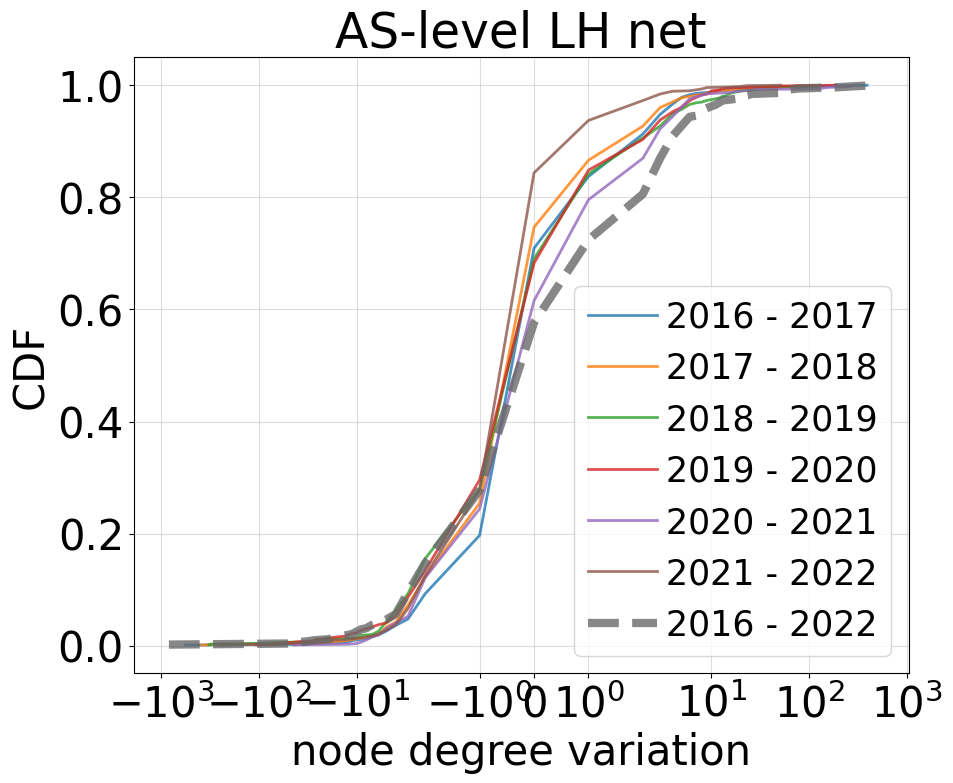

In [25]:
fig, ax = plt.subplots(1, figsize=(10, 8), sharey=True)

ax.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
ax.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')


for i in range(1, len(cycles)):
    tmp = yoy.loc[yoy["cycle"] == cycles[i]]
    
    d = tmp.groupby("variation")["cycle"] \
        .count() \
        .reset_index() \
        .sort_values("variation")

    ax.plot(
        d["variation"].values,
        d["cycle"].cumsum() / d["cycle"].sum(),
        label=f"{cycle2year[cycles[i -1]]} - {cycle2year[cycles[i]]}",
        alpha=0.8,
        lw=2,
    )

    
d = e2e.groupby("variation")["asn"] \
    .count() \
    .reset_index() \
    .sort_values("variation")

ax.plot(
    d["variation"].values,
    d["asn"].cumsum() / d["asn"].sum(),
    label=f"{cycle2year[cycles[0]]} - {cycle2year[cycles[-1]]}",
    lw=6,
    alpha=0.8,
    color="dimgrey",
    ls="--"
)

# ax.set_xlim(np.percentile(d["variation"], 5), np.percentile(d["variation"], 95))

FONTSIZE = 30

ax.set_xscale('symlog')
# ax.set_yscale('log')

ax.tick_params(labelsize=FONTSIZE)
ax.set_ylabel('CDF', fontsize=FONTSIZE)
ax.set_xlabel('node degree variation', fontsize=FONTSIZE)

ax.legend(loc='lower right', ncol=1, frameon=True, fontsize=25,
          handletextpad=0.25, columnspacing=0.5, handlelength=2)

ax.set_title("AS-level LH net", fontsize=35)
# fig.savefig("figures/lhnet/node_variation_asn.pdf")

In [26]:
e2e["variation"].mean(), e2e["variation"].median()

(1.1106796116504853, 0.0)

In [27]:
e2e.sort_values("variation").head(10)

,asn,variation
32,3549,-827
21,3257,-47
17,3491,-42
209,20485,-32
27,6762,-27
91,9304,-19
10,0,-18
3,2914,-17
7,9498,-12
24,209,-12


In [28]:
e2e.sort_values("variation").tail(10)

,asn,variation
18,20940,24
210,34224,25
69,174,52
128,35432,56
197,6939,61
489,25091,62
165,3356,76
50,6453,179
242,32787,282
102,1299,451


In [29]:
c = pd.DataFrame()

for cycle in [4577, 5423, 6447, 7616, 8821, 9644, 10020]:
    # concat_df = pd.DataFrame()
    # for _cycle in range(cycle -1, cycle + 2):
    #     concat_df = pd.concat([concat_df, filtered_geoloc_hops[_cycle]])
    
    df = pd.read_csv(f"data/processed/snapshots-longitudinal/{cycle}.csv.gz", compression="gzip")
    G = generate_graph(df)
    
    Gcc = nx.Graph()
    
    for n1 in G.nodes():
        for n2 in G.neighbors(n1):
            if G.nodes[n1]["cc"] != G.nodes[n2]["cc"]:
                Gcc.add_edge(G.nodes[n1]["cc"], G.nodes[n2]["cc"])
    
    tmp = pd.DataFrame(dict(Gcc.degree()).items(), columns=["node", "degree"])
    tmp["cycle"] = np.repeat(cycle, tmp.shape[0])
    
    c = pd.concat([c, tmp])

In [30]:
c.head()

,node,degree,cycle
0,AE,7,4577
1,KE,4,4577
2,AT,5,4577
3,US,87,4577
4,AU,17,4577


In [31]:
cycles = [4577, 5423, 6447, 7616, 8821, 9644, 10020]

yoy = []
e2e = []

for cc in c.drop_duplicates("node")["node"].values:
    
    tmp = c.loc[c["node"] == cc]
    
    for i in range(1, len(cycles)):
        x = tmp.loc[tmp["cycle"] == cycles[i - 1]]["degree"]
        y = tmp.loc[tmp["cycle"] == cycles[i]]["degree"]
        
        if len(x) > 0 and len(y) > 0:
            yoy.append((cycles[i], cc, y.values[0] - x.values[0]))
        
    x = tmp.loc[tmp["cycle"] == cycles[0]]["degree"]
    y = tmp.loc[tmp["cycle"] == cycles[-1]]["degree"]
    
    if len(x) > 0 and len(y) > 0:
        e2e.append((cc, y.values[0] - x.values[0]))

In [32]:
yoy = pd.DataFrame(yoy, columns=["cycle", "cc", "variation"])
yoy.head()

,cycle,cc,variation
0,5423,AE,1
1,6447,AE,4
2,7616,AE,-1
3,8821,AE,1
4,9644,AE,2


In [33]:
e2e = pd.DataFrame(e2e, columns=["cc", "variation"])
e2e.head()

,cc,variation
0,AE,6
1,KE,10
2,AT,15
3,US,24
4,AU,29


Text(0.5, 1.0, 'country-level LH net')

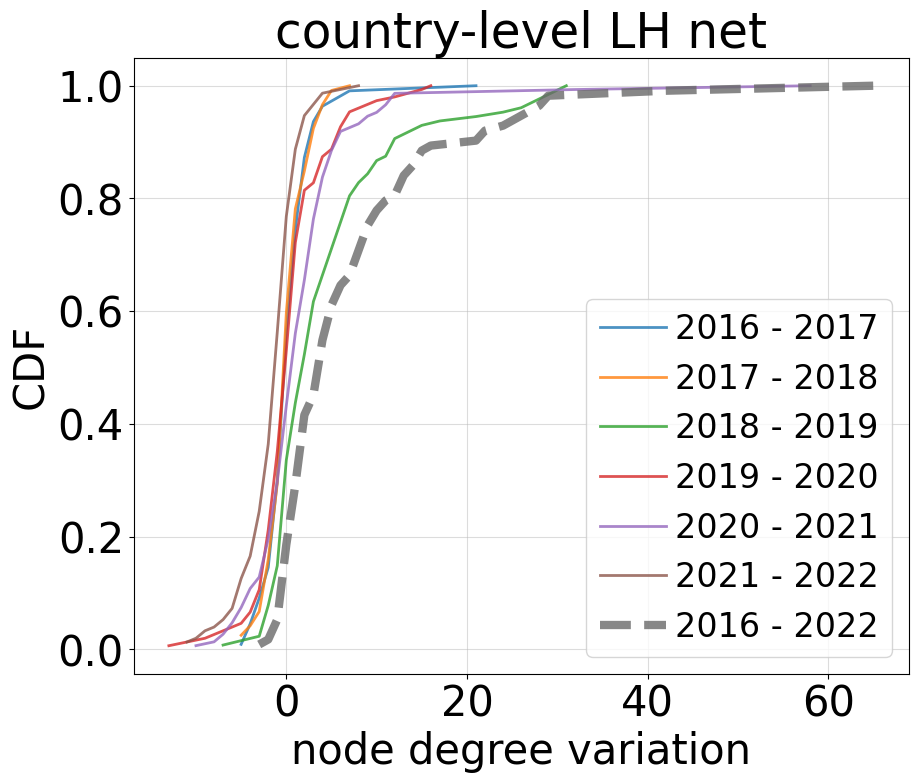

In [34]:
fig, ax = plt.subplots(1, figsize=(10, 8), sharey=True)

ax.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
ax.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')


for i in range(1, len(cycles)):
    tmp = yoy.loc[yoy["cycle"] == cycles[i]]
    
    d = tmp.groupby("variation")["cycle"] \
        .count() \
        .reset_index() \
        .sort_values("variation")

    ax.plot(
        d["variation"].values,
        d["cycle"].cumsum() / d["cycle"].sum(),
        label=f"{cycle2year[cycles[i -1]]} - {cycle2year[cycles[i]]}",
        alpha=0.8,
        lw=2,
    )

    
d = e2e.groupby("variation")["cc"] \
    .count() \
    .reset_index() \
    .sort_values("variation")

ax.plot(
    d["variation"].values,
    d["cc"].cumsum() / d["cc"].sum(),
    label=f"{cycle2year[cycles[0]]} - {cycle2year[cycles[-1]]}",
    lw=6,
    alpha=0.8,
    color="dimgrey",
    ls="--"
)


FONTSIZE = 30

ax.tick_params(labelsize=FONTSIZE)
ax.set_ylabel('CDF', fontsize=FONTSIZE)
ax.set_xlabel('node degree variation', fontsize=FONTSIZE)

ax.legend(loc='lower right', ncol=1, frameon=True, fontsize=24,
          handletextpad=0.25, columnspacing=0.5, handlelength=2)

ax.set_title("country-level LH net", fontsize=35)
# fig.savefig("figures/lhnet/node_variation_cc.pdf")

In [35]:
e2e["variation"].mean(), e2e["variation"].median()

(7.176991150442478, 4.0)

In [36]:
e2e.sort_values("variation").head(10)

,cc,variation
10,KR,-3
36,SA,-2
92,BW,-1
105,UZ,-1
52,AM,-1
47,PY,-1
87,MW,0
86,KZ,0
32,GE,0
83,AF,0


In [37]:
e2e.sort_values("variation").tail(10)

,cc,variation
11,NL,22
3,US,24
7,FR,26
9,JP,26
44,ES,27
6,HK,28
20,BR,29
4,AU,29
27,CA,42
38,SE,65
